In [7]:
import sys
sys.path.append("..")

import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from src.mha import MultiHeadAttention, EnhancedMultiHeadAttention

## Multi-Head Attention Visualization

### Attention Weight Visualization

In [8]:
def visualize_attention(attention_weights):
    """Visualize attention weights across different heads.
    Args:
        attention_weights: tensor of shape [batch_size, num_heads, seq_len, seq_len]
    """
    num_heads = attention_weights.shape[1]
    attn = attention_weights[0].detach().cpu().numpy()
    
    cols = min(4, num_heads)
    rows = (num_heads + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows))
    axes = axes.flatten() if num_heads > 1 else [axes]
    
    for head_idx in range(num_heads):
        ax = axes[head_idx]
        im = ax.imshow(attn[head_idx])
        ax.set_title(f'Head {head_idx}')
        ax.set_xlabel('Key')
        ax.set_ylabel('Query')
        plt.colorbar(im, ax=ax)
    
    fig.suptitle("Attention Weights")
    plt.tight_layout()
    return fig

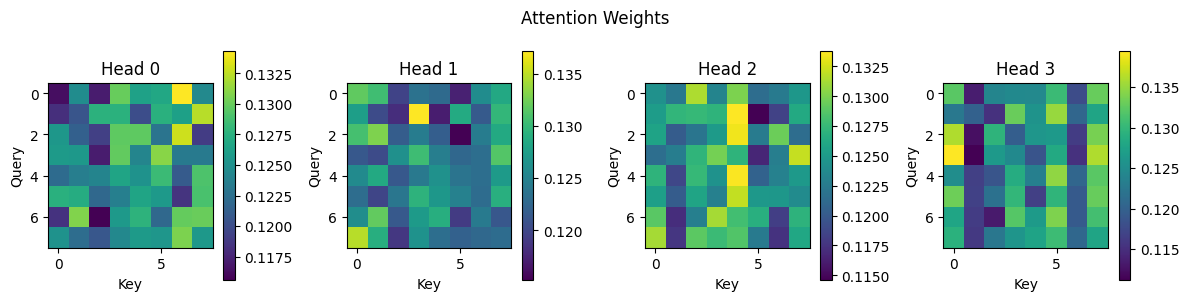

In [9]:
batch_size = 1
seq_length = 8
d_model = 64
num_heads = 4

x = torch.rand(batch_size, seq_length, d_model)
mha = MultiHeadAttention(d_model, num_heads)

output, attn_weights = mha(x)

visualize_attention(attn_weights)
plt.show()

### Attention Weight Visualization With Dropout / LayerNorm & Causal Masking

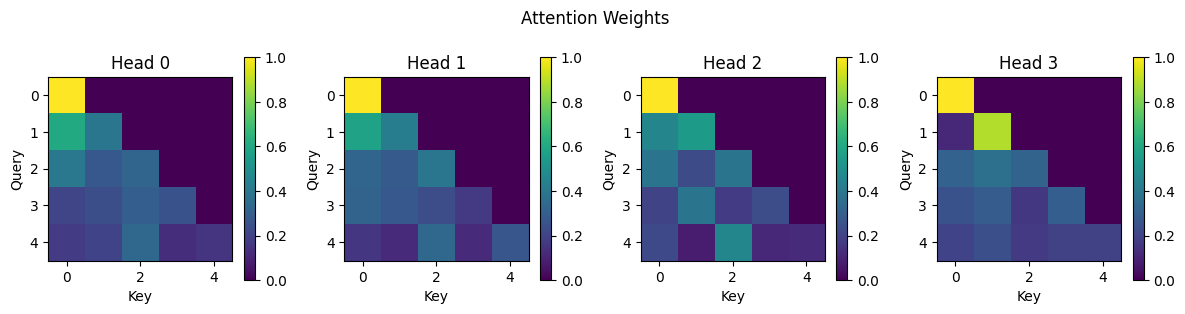

In [10]:
batch_size = 1
seq_length = 5
d_model = 16
num_heads = 4

x = torch.rand(batch_size, seq_length, d_model)
mha = EnhancedMultiHeadAttention(d_model, num_heads, dropout=0.1, use_causal_mask=True)

output, attn_weights = mha(x)
visualize_attention(attn_weights)
plt.show()

## Throughput Micro-Benchmarks

In [ ]:
def benchmark_attention(model, x, num_iterations=100, is_torch_mha=False):
    """Benchmark attention module.
    Args:
        model: attention module
        x: input tensor
        num_iterations: number of forward passes
        is_torch_mha: whether this is PyTorch's MultiheadAttention
    Returns:
        Average time in milliseconds
    """

    start = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            if is_torch_mha:
                _ = model(x, x, x)
            else:
                _ = model(x)
    
    elapsed = time.time() - start
    return elapsed / num_iterations * 1000

In [12]:
d_model = 64
num_heads = 8
batch_size = 4
seq_lengths = [128, 256]
num_iterations = 100

results = {"ours": [], "torch": [], "enhanced": [], "seq_len": seq_lengths}

print("Sequence Length | PyTorch   | Our Implementation | Enhanced")
print("-" * 60)

for seq_len in seq_lengths:
    x = torch.randn(batch_size, seq_len, d_model)
    
    # Our implementation
    mha_ours = MultiHeadAttention(d_model, num_heads)
    mha_ours.eval()
    time_ours = benchmark_attention(mha_ours, x, num_iterations)
    results["ours"].append(time_ours)

    # Our implementation with enhancements
    mha_ours_enhanced = EnhancedMultiHeadAttention(d_model, num_heads)
    mha_ours_enhanced.eval()
    time_ours_enhanced = benchmark_attention(mha_ours_enhanced, x, num_iterations)
    results["enhanced"].append(time_ours_enhanced)

    # PyTorch implementation
    mha_torch = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
    mha_torch.eval()
    time_torch = benchmark_attention(mha_torch, x, num_iterations, is_torch_mha=True)
    results["torch"].append(time_torch)

    print(f"{seq_len:15d} | {time_torch:7.4f}ms | {time_ours:16.4f}ms | {time_ours_enhanced:7.4f}ms")

Sequence Length | PyTorch   | Our Implementation | Enhanced
------------------------------------------------------------
            128 |  0.4473ms |           0.4061ms |  0.4648ms
            256 |  1.0037ms |           1.1570ms |  1.2331ms
